# Projet 5 : Segmentez des clients d'un site e-commerce

## Notebook 1 : Analyse exploratoire

In [111]:
# importation des bibliothèques nécessaires
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [112]:
# importation des datasets
customers_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_orders_dataset.csv')
products_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_products_dataset.csv')
sellers_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_sellers_dataset.csv')
product_category_name_translation = pd.read_csv('brazilian_ecommerce_dataset/product_category_name_translation.csv')


In [113]:
#Fonction qui retourne un tableau contenant le nom de la variable, le nombre de valeur manquante ainsi que le 
#pourcentage de valeurs manquantes associé

def missingValues(df):
    df_null = pd.DataFrame({'Count' : df.isnull().sum(), 'Percentage': round(100*df.isnull().sum()/len(df),2)})
    df_null_pos = df_null[df_null['Count'] > 0 ]
    df_null_sorted = df_null_pos.sort_values(by=['Percentage'], ascending = False)
    df_null_sorted = pd.DataFrame(df_null_sorted)
    df_null_sorted.reset_index(inplace = True)
    df_null_sorted.rename(columns={'index':'Variable Name'}, inplace=True)
    return df_null_sorted

#Cette fonction permet de supprimer les variables avec un pourcentage de valeur manquante supérieur à la limite

def dropColumns(df, limit):
    tab = missingValues(df)
    columns_to_keep = list()

    for row in tab.iterrows():        
        if float(row[1]['Percentage']) < float(limit):
            columns_to_keep.append(row[1]['Variable Name'])
            
    data = df[columns_to_keep]
    return data

## Exploration des données 

### Dataset des clients 

- customer_id : identifiant client par commande
- customer_unique id : identifiant unique du client

Un client peut avoir plusieurs customer_id mais est rattaché à un seul customer_unique_id
- customer_zip_code_prefix : variable clé 

In [114]:
customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [115]:
customers_dataset.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


In [116]:
customers_dataset.describe(exclude = [np.number])

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


In [117]:
#Ce client a réalisé 17 commandes
customers_dataset[customers_dataset['customer_unique_id'] == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
14186,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
15321,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
16654,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
36122,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
38073,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
40141,dfb941d6f7b02f57a44c3b7c3fefb44b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
48614,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
52574,1c62b48fb34ee043310dcb233caabd2e,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
58707,a682769c4bc10fc6ef2101337a6c83c9,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
67996,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP


In [118]:
customers_dataset.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [119]:
# On regarde les valeurs manquantes
missingValues(customers_dataset)

#Pas de valeurs manquantes

,Variable Name,Count,Percentage


In [120]:
#On crée un dataset pour avoir le nombre de commandes par client
customers_dataset_gb = customers_dataset.groupby(['customer_unique_id']).count().sort_values(by=['customer_id'],ascending = False)[['customer_id']].reset_index()
customers_dataset_gb = customers_dataset_gb.groupby(['customer_id']).count().reset_index()
customers_dataset_gb


,customer_id,customer_unique_id
0,1,93099
1,2,2745
2,3,203
3,4,30
4,5,8
5,6,6
6,7,3
7,9,1
8,17,1


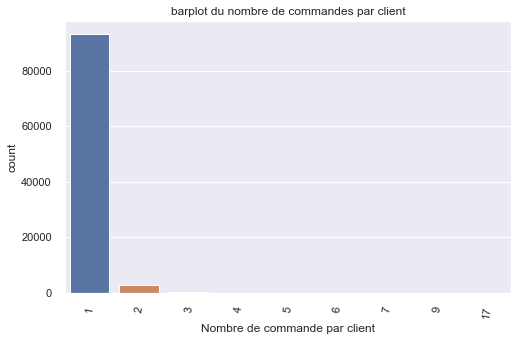

In [121]:
#Barplot of Primary Property Type
sns.set(rc={'figure.figsize':(8,5)})
g = sns.barplot(x=customers_dataset_gb['customer_id'], y=customers_dataset_gb['customer_unique_id'])
g.set_xticklabels(g.get_xticklabels(), rotation=80)
g.set(xlabel ='Nombre de commande par client', ylabel = 'count', title ='barplot du nombre de commandes par client');


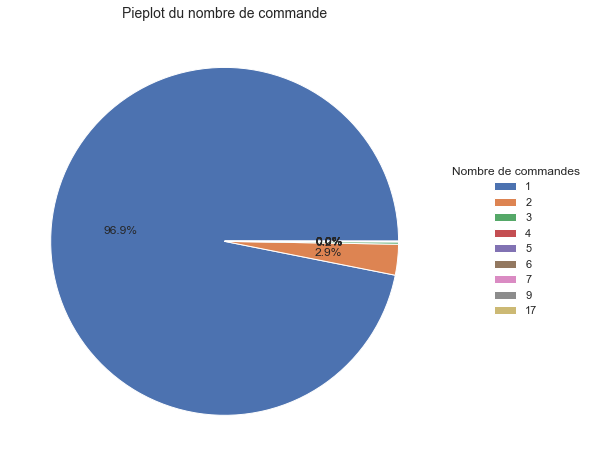

In [122]:
fig, ax = plt.subplots(figsize=(15,8), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(customers_dataset_gb['customer_unique_id'],
                                  autopct='%1.1f%%')

ax.legend(wedges, customers_dataset_gb['customer_id'],
          title="Nombre de commandes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12)
ax.set_title("Pieplot du nombre de commande", size=14)

plt.show()

On voit qu'il y que 3% des clients qui ont fait plus d'une commande

### Dataset geolocalisation

- geolocation_zip_code_prefix : variable clé

In [123]:
geolocation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [124]:
geolocation_dataset.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [125]:
geolocation_dataset.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


In [126]:
geolocation_dataset.describe(exclude = [np.number])

,geolocation_city,geolocation_state
count,1000163,1000163
unique,8011,27
top,sao paulo,SP
freq,135800,404268


In [127]:
# On regarde les valeurs manquantes
missingValues(geolocation_dataset)
#Pas de valeurs manquantes

,Variable Name,Count,Percentage


### Dataset des articles

- order_id : identifiant de commande : variable clé 
- product_id : identifiant du produit : variable clé
- seller_id : identifiant du vendeur

In [128]:
order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [129]:
order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [130]:
order_items_dataset.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [131]:
order_items_dataset.describe(exclude = [np.number])

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


In [132]:
# On regarde les valeurs manquantes
missingValues(order_items_dataset)

#Pas de valeurs manquantes

,Variable Name,Count,Percentage


### Dataset des paiements 

- order_id : identifiant des commandes : variable clé 
- payment_sequential : Si plusieurs méthodes de paiement appliquées, une ligne est crée par moyen utilisé 
- payment_installments : Nombre de versements choisis

In [133]:
order_payments_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [134]:
order_payments_dataset[order_payments_dataset['order_id'] == "31bc09fdbd701a7a4f9b55b5955b8687"]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
27995,31bc09fdbd701a7a4f9b55b5955b8687,3,voucher,1,37.88
39416,31bc09fdbd701a7a4f9b55b5955b8687,7,voucher,1,3.48
43160,31bc09fdbd701a7a4f9b55b5955b8687,4,voucher,1,40.33
45492,31bc09fdbd701a7a4f9b55b5955b8687,1,voucher,1,26.86
74317,31bc09fdbd701a7a4f9b55b5955b8687,5,voucher,1,22.28
82459,31bc09fdbd701a7a4f9b55b5955b8687,2,voucher,1,55.71
103860,31bc09fdbd701a7a4f9b55b5955b8687,6,voucher,1,77.99


In [135]:
order_payments_dataset.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [136]:
order_payments_dataset.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [137]:
order_payments_dataset.describe(exclude = [np.number])

,order_id,payment_type
count,103886,103886
unique,99440,5
top,fa65dad1b0e818e3ccc5cb0e39231352,credit_card
freq,29,76795


In [138]:
# On regarde les valeurs manquantes
missingValues(order_payments_dataset)

#Pas de valeurs manquantes

,Variable Name,Count,Percentage


### Dataset des avis clients

- review_id : variable clé

In [139]:
order_reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [140]:
# col order_id and review_id
order_reviews_dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [141]:
order_reviews_dataset.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [142]:
order_reviews_dataset.describe(exclude = [np.number])

,review_id,order_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,11568,40977,99224,99224
unique,98410,98673,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,423,230,463,4


In [143]:
# On regarde les valeurs manquantes
missingValues(order_reviews_dataset)

# 2 variables ont des valeurs manquantes : review_comment_title et review_comment_message


,Variable Name,Count,Percentage
0,review_comment_title,87656,88.34
1,review_comment_message,58247,58.70


### Dataset des commandes

- order_id : identifiant de la commande : variable clé
- customer_id : identifiant du client : variable clé

In [144]:
orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [145]:
orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [146]:
orders_dataset.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [147]:
orders_dataset.describe(exclude = [np.number])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [148]:
# On regarde les valeurs manquantes
missingValues(orders_dataset)

,Variable Name,Count,Percentage
0,order_delivered_customer_date,2965,2.98
1,order_delivered_carrier_date,1783,1.79
2,order_approved_at,160,0.16


### Dataset des articles

- product_id : identifiant produit : variable clé

In [149]:
products_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [150]:
products_dataset.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [151]:
products_dataset.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [152]:
products_dataset.describe(exclude = [np.number])

,product_id,product_category_name
count,32951,32341
unique,32951,73
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho
freq,1,3029


In [153]:
# On regarde les valeurs manquantes
missingValues(products_dataset)

,Variable Name,Count,Percentage
0,product_category_name,610,1.85
1,product_name_lenght,610,1.85
2,product_description_lenght,610,1.85
3,product_photos_qty,610,1.85
4,product_weight_g,2,0.01
5,product_length_cm,2,0.01
6,product_height_cm,2,0.01
7,product_width_cm,2,0.01


### Dataset des vendeurs

- seller_id : identifiant des vendeurs : variable clé

In [154]:
sellers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [155]:
sellers_dataset.describe()

,seller_zip_code_prefix
count,3095.000000
mean,32291.059451
std,32713.453830
min,1001.000000
25%,7093.500000
50%,14940.000000
75%,64552.500000
max,99730.000000


In [156]:
sellers_dataset.describe(exclude = [np.number])

,seller_id,seller_city,seller_state
count,3095,3095,3095
unique,3095,611,23
top,3442f8959a84dea7ee197c632cb2df15,sao paulo,SP
freq,1,694,1849


In [157]:
sellers_dataset.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [158]:
# On regarde les valeurs manquantes
missingValues(sellers_dataset)

#Pas de valeurs manquantes

,Variable Name,Count,Percentage


### Dataset des catégories traduites

- product_category_name : variable clé 

In [159]:
product_category_name_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [160]:
product_category_name_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [161]:
# On regarde les valeurs manquantes
missingValues(product_category_name_translation)

,Variable Name,Count,Percentage


## Jointure des datasets : préparation du dataset des commandes

### On part du dataframe des commandes : on le merge avec le dataset des clients

In [162]:
orders_customers_df = orders_dataset.merge(customers_dataset, 
                                              how='outer',
                                              indicator = True,
                                              on='customer_id')
orders_customers_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,both
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,both
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,both
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,both
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,both


In [163]:
# On remarque qu'il n'y a pas de données manquantes
# Tous les clients sont rattachés à une commande et inverse
#Un client qui n'est rattaché à aucunes commandes ne nous interesse pas

orders_customers_df.groupby(['_merge']).count()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
_merge,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0
both,99441,99441,99441,99441,99281,97658,96476,99441,99441,99441,99441,99441


In [164]:
#On peut supprimer la variable "order_status" qui est une valeur unique
orders_customers_df.drop(columns = ['_merge'],inplace = True)

In [165]:
#On va mettre les variables sous forme de date
orders_customers_df['order_purchase_timestamp'] = orders_customers_df['order_purchase_timestamp'].astype('datetime64[ns]')
orders_customers_df['order_delivered_customer_date'] = orders_customers_df['order_delivered_customer_date'].astype('datetime64[ns]')


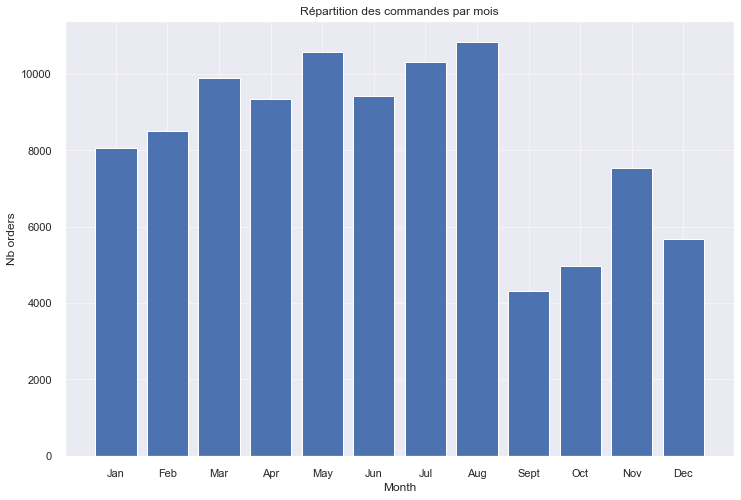

In [166]:
# Bar plot de la repartition des commandes par mois
fig, ax = plt.subplots(figsize=(12, 8))
df = orders_customers_df.groupby(orders_customers_df['order_purchase_timestamp'].dt.month).agg({"order_id": "nunique"})
df['mois'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']

ax.bar(df['mois'], df['order_id']) 
plt.xlabel("Month")
plt.title("Répartition des commandes par mois")
plt.ylabel("Nb orders")
ax.grid(True,alpha=0.5)
ax.set_axisbelow(True)
plt.show()

Text(0, 0.5, 'Nombre de lignes')

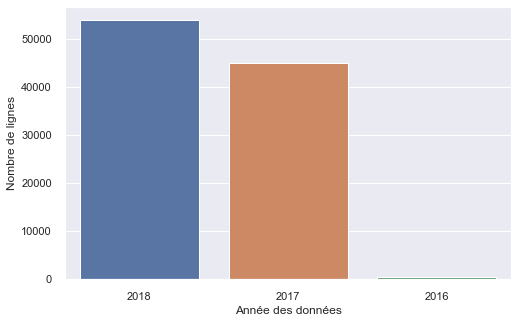

In [167]:
#On regarde les années où les commandes ont été réalisés
orders_customers_df['order_purchase_year'] = orders_customers_df.order_purchase_timestamp.apply(lambda x: x.year)

sns.countplot(x = orders_customers_df['order_purchase_year'],
              order = orders_customers_df['order_purchase_year'].value_counts().index,
              data= orders_customers_df);
orders_customers_df = orders_customers_df.drop('order_purchase_year', axis = 1)
plt.xlabel('Année des données')
plt.ylabel('Nombre de lignes')

In [168]:
missingValues(orders_customers_df)

,Variable Name,Count,Percentage
0,order_delivered_customer_date,2965,2.98
1,order_delivered_carrier_date,1783,1.79
2,order_approved_at,160,0.16


### Dataset des commandes clients et commandes : on le merge avec le dataset des articles de commandes

In [169]:
#On merge le dataframe des article de commande au dataset des commandes à l'aide de l'order_id 
#qui est commun à ces deux dataframes

orders_customers_items_df = orders_customers_df.merge(order_items_dataset, on='order_id', how ='outer', indicator=True)
orders_customers_items_df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,both
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,both
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,both
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,both
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,both


In [170]:
orders_customers_items_df.groupby(['_merge']).count()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
_merge,,,,,,,,,,,,,,,,,,
left_only,775,775,775,775,629,1,0,775,775,775,775,775,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,112650,112650,112650,112650,112635,111456,110196,112650,112650,112650,112650,112650,112650,112650,112650,112650,112650,112650


In [171]:
# On voit que les jointures que sur le dataframe de gauche se font pour des order_status :
# unavailable, canceled, created, invoiced and shipped
# On va donc supprimer les order status qui ne nous interesse pas et garde que le status "shipped"

orders_customers_items_df[orders_customers_items_df['_merge'] == 'left_only'].groupby(['order_status']).count()
                                                                

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,_merge
order_status,,,,,,,,,,,,,,,,,,
canceled,164,164,164,23,0,0,164,164,164,164,164,0,0,0,0,0,0,164
created,5,5,5,0,0,0,5,5,5,5,5,0,0,0,0,0,0,5
invoiced,2,2,2,2,0,0,2,2,2,2,2,0,0,0,0,0,0,2
shipped,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,1
unavailable,603,603,603,603,0,0,603,603,603,603,603,0,0,0,0,0,0,603


In [172]:
#On supprime les colonnes dont on a pas besoin 
orders_customers_items_df.drop(["order_delivered_carrier_date",
                     "order_estimated_delivery_date",
                     "shipping_limit_date",
                     "order_approved_at",
                    "seller_id"], axis=1, inplace=True)

In [173]:
#On regarde les différents status de commande
orders_customers_items_df.groupby(by="order_status").sum()["order_item_id"]

order_status
approved            4.0
canceled          704.0
created             0.0
delivered      132036.0
invoiced          435.0
processing        455.0
shipped          1294.0
unavailable         8.0
Name: order_item_id, dtype: float64

In [174]:
#On ne va garder que les commandes qui ont été réalisés et supprimer les autres
orders_customers_items_df = orders_customers_items_df[orders_customers_items_df["order_status"] == "delivered"]

#On peut supprimer la variable "order_status" qui est une valeur unique
orders_customers_items_df.drop(columns = ["order_status"],inplace = True)

In [175]:
#On verifie les jointures et on voit qu'il n'y a que des jointures sur les deux dataframes
orders_customers_items_df.groupby(['_merge']).count()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,price,freight_value
_merge,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0
both,110197,110197,110197,110189,110197,110197,110197,110197,110197,110197,110197,110197


In [176]:
#On peut supprimer la variable '_merge' on en a plus besoin
orders_customers_items_df.drop(columns = ["_merge"],inplace = True)

In [177]:
missingValues(orders_customers_items_df)

,Variable Name,Count,Percentage
0,order_delivered_customer_date,8,0.01


### On merge les informations de paiements au dataframe des commandes

In [178]:
# On merge les informations de paiement 
# On décide de faire un merge 'left' car les commandes sans informations de paiement ne nous interessent pas
orders_customers_items_payments_df = orders_customers_items_df.merge(order_payments_dataset, 
                                                            how='left',
                                                            indicator=True,
                                                            on='order_id')

In [179]:
# On voit qu'il n'y a que 3 commandes où les informations de paiements ne sont pas rattachées
orders_customers_items_payments_df.groupby(['_merge']).count()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
_merge,,,,,,,,,,,,,,,,
left_only,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,115035,115035,115035,115027,115035,115035,115035,115035,115035,115035,115035,115035,115035,115035,115035,115035


In [180]:
orders_customers_items_payments_df[orders_customers_items_payments_df['_merge'] == 'left_only']

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,_merge
35616,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,2016-11-09 07:47:38,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,1.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,2.83,NaN,NaN,NaN,NaN,left_only
35617,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,2016-11-09 07:47:38,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,2.83,NaN,NaN,NaN,NaN,left_only
35618,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,2016-11-09 07:47:38,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,3.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,2.83,NaN,NaN,NaN,NaN,left_only


In [181]:
#On decide de supprimer les cas "left_only"
#car on ne veut que les commandes etant rattachés à un paiment
index_to_drop = orders_customers_items_payments_df[orders_customers_items_payments_df['_merge'] == 'left_only'].index
orders_customers_items_payments_df.drop(index = index_to_drop, inplace = True)

In [182]:
#On peut supprimer la variable '_merge' on en a plus besoin
orders_customers_items_payments_df.drop(columns = ["_merge"],inplace = True)

In [183]:
missingValues(orders_customers_items_payments_df)

,Variable Name,Count,Percentage
0,order_delivered_customer_date,8,0.01


### On merge les avis clients

In [184]:
# On merge des avis clients
#On decide de faire un merge left car 
orders_customers_items_payments_reviews_df = orders_customers_items_payments_df.merge(order_reviews_dataset,
                                                                                      how='left',
                                                                                      indicator=True,
                                                                                      on='order_id')

In [185]:
# On voit qu'il y a 861 lignes qui ne sont pas rattaché à un avis
orders_customers_items_payments_reviews_df.groupby(['_merge']).count()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
_merge,,,,,,,,,,,,,,,,,,,,,,
left_only,861,861,861,861,861,861,861,861,861,861,861,861,861,861,861,861,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,114859,114859,114859,114851,114859,114859,114859,114859,114859,114859,114859,114859,114859,114859,114859,114859,114859,114859,13584,48092,114859,114859


In [186]:
# On regarde les lignes où il n'y a pas de reviews
orders_customers_items_payments_reviews_df[orders_customers_items_payments_reviews_df['_merge'] == 'left_only']

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,_merge
19,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,2018-01-02 19:00:43,2018-01-20 01:38:59,6e26bbeaa107ec34112c64e1ee31c0f5,21381,rio de janeiro,RJ,1.0,638bbb2a5e4f360b71f332ddfebfd672,1299.00,77.45,1.0,credit_card,10.0,1376.45,NaN,NaN,NaN,NaN,NaN,NaN,left_only
361,4906eeadde5f70b308c20c4a8f20be02,4e7656e34357b93f14b40c6400ca3f6e,2017-12-08 04:45:26,2018-01-09 18:04:58,ea870f4fdfd85ac98ab775b76efe3143,23065,rio de janeiro,RJ,1.0,ee406bf28024d97771c4b1e8b7e8e219,144.99,17.26,1.0,boleto,1.0,162.25,NaN,NaN,NaN,NaN,NaN,NaN,left_only
442,b7a4a9ecb1cd3ef6a3e36a48e200e3be,c3d8fc500d86b1c961ee144395c13a57,2017-05-19 18:13:54,2017-06-08 07:53:42,367f4686d7112d69feed92b02a1775ed,88501,lages,SC,1.0,41171e11f920c47deb1809edda2bf09d,26.00,15.10,1.0,credit_card,4.0,41.10,NaN,NaN,NaN,NaN,NaN,NaN,left_only
450,59b32faedc12322c672e95ec3716d614,5baa82a2c45fa3220cb57d9881db3211,2018-06-27 11:10:11,2018-07-06 16:37:36,c56d066e503008b8d0bf4204857c588d,97110,santa maria,RS,1.0,040f34fe061b6024771f641fe922e782,69.00,18.58,1.0,boleto,1.0,87.58,NaN,NaN,NaN,NaN,NaN,NaN,left_only
471,c2215076050fa358934105b15c34cf3b,19e7a88b34ef70d108e660c6eb33e82a,2017-07-16 10:04:36,2017-07-26 20:32:17,f329e0e1d8897ffa466a836ed216a23b,3884,sao paulo,SP,1.0,99a4788cb24856965c36a24e339b6058,89.90,12.13,1.0,credit_card,2.0,102.03,NaN,NaN,NaN,NaN,NaN,NaN,left_only
622,eafef0e6c44f121531569a69a318c3b3,084dab2db2bf5d42677b135e633a15ba,2017-11-29 13:03:33,2018-01-09 16:32:21,ec85abbbac44c1bb668a04903d033b6d,90410,porto alegre,RS,1.0,e1901d5d99ca951543717ea5d1940a36,65.99,15.22,1.0,credit_card,3.0,81.21,NaN,NaN,NaN,NaN,NaN,NaN,left_only
977,95d9d2979d40161be87292ff88563cba,e4721b61e8d2b4b85d606809f6baa292,2018-06-07 23:42:37,2018-06-16 16:44:34,dfe0f45b0b8cf0ce9c4cfb41c0808240,4023,sao paulo,SP,1.0,634256dbcd184b3757ffd7632c9fe52a,24.90,7.39,1.0,credit_card,3.0,64.58,NaN,NaN,NaN,NaN,NaN,NaN,left_only
978,95d9d2979d40161be87292ff88563cba,e4721b61e8d2b4b85d606809f6baa292,2018-06-07 23:42:37,2018-06-16 16:44:34,dfe0f45b0b8cf0ce9c4cfb41c0808240,4023,sao paulo,SP,2.0,634256dbcd184b3757ffd7632c9fe52a,24.90,7.39,1.0,credit_card,3.0,64.58,NaN,NaN,NaN,NaN,NaN,NaN,left_only
980,a9b151f0c0471d9b2534fa73c9c0e123,2238c417bc745d8fa7d7389d8b22154b,2017-03-09 16:18:47,2017-03-16 12:45:39,2990f218665832600f7180650703052d,21011,rio de janeiro,RJ,1.0,fc5043902812d122c4e80113ff924c1b,159.90,46.61,1.0,credit_card,3.0,206.51,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1227,5e8d0f2f1e06e715aee3eefe4c175e52,743dd95aefb65359afe92a764748251a,2017-11-28 22:50:22,2017-12-26 17:38:50,2e9cdecaa137e8ba2084bbde28c85105,22270,rio de janeiro,RJ,1.0,5cd07c84a1c25575ac2fc3fa73f1d952,597.90,21.44,1.0,credit_card,10.0,619.34,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [187]:
#On regarde les valeurs manquantes 
missingValues(orders_customers_items_payments_reviews_df)

,Variable Name,Count,Percentage
0,review_comment_title,102136,88.26
1,review_comment_message,67628,58.44
2,review_id,861,0.74
3,review_score,861,0.74
4,review_creation_date,861,0.74
5,review_answer_timestamp,861,0.74
6,order_delivered_customer_date,8,0.01


In [188]:
#On peut supprimer la variable '_merge' on en a plus besoin
orders_customers_items_payments_reviews_df.drop(columns = ["_merge"],inplace = True)

In [189]:
#On supprime les variables inutiles et celles avec trop de valeurs manquantes
orders_customers_items_payments_reviews_df.drop(columns = ['review_comment_title',
                                                           'review_comment_message',
                                                          'review_creation_date',
                                                          'review_answer_timestamp',
                                                           'review_id'
                                                          ], inplace = True)

In [190]:
# On supprime les lignes ou il y a des valeurs manquantes pour la variable order_delivered_customer_date
orders_customers_items_payments_reviews_df = orders_customers_items_payments_reviews_df.dropna(subset = ['order_delivered_customer_date'], axis =0)

In [191]:
orders_customers_items_payments_reviews_df['review_score'] = orders_customers_items_payments_reviews_df['review_score'].fillna(orders_customers_items_payments_reviews_df['review_score'].mean())


In [192]:
missingValues(orders_customers_items_payments_reviews_df)

,Variable Name,Count,Percentage


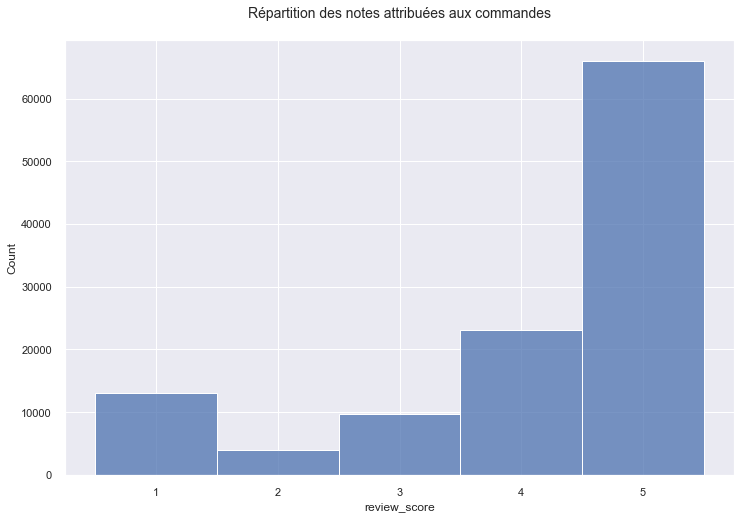

In [213]:
#Histplot des notes attribuées aux commandes
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=orders_customers_items_payments_reviews_df, x="review_score",discrete=True)
plt.title(f"Répartition des notes attribuées aux commandes\n", size = 14)
plt.show()

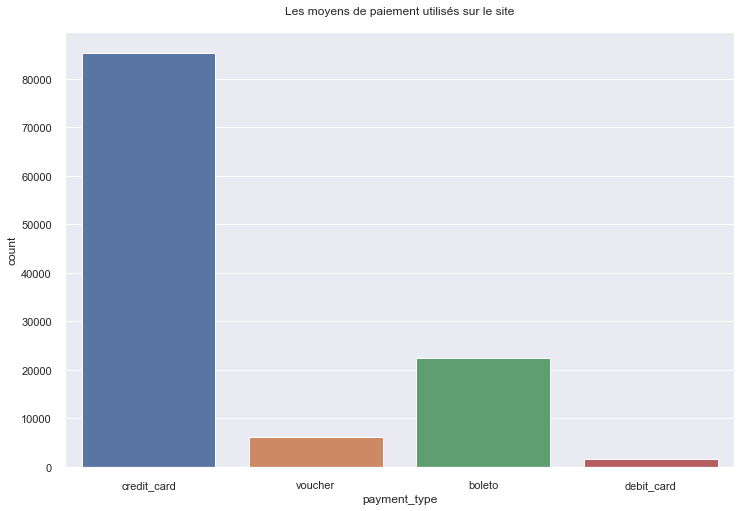

In [194]:
# Countplot des moyens de payments
fig = plt.figure(figsize=(12, 8))
sns.countplot(data=orders_customers_items_payments_reviews_df, x="payment_type")
plt.title(f"Les moyens de paiement utilisés sur le site\n")
plt.show()

### Dataset Produit qui va être rattaché aux commandes
On merge products_dataset et product_category_name_translation

In [195]:
missingValues(products_dataset)

,Variable Name,Count,Percentage
0,product_category_name,610,1.85
1,product_name_lenght,610,1.85
2,product_description_lenght,610,1.85
3,product_photos_qty,610,1.85
4,product_weight_g,2,0.01
5,product_length_cm,2,0.01
6,product_height_cm,2,0.01
7,product_width_cm,2,0.01


In [196]:
# On rempli les valeurs manquantes de catégorie de produits par unknown
products_dataset['product_category_name'] = products_dataset['product_category_name'].fillna('Unknown')

In [197]:
#On crée un dictionnaire de mapping pour avoir la traduction de la colonne de catégorie de product
mapping = dict(product_category_name_translation[['product_category_name', 'product_category_name_english']].values)
#On ajoute au dataframe products_dataset la traduction anglaise de 'product_category_name'
products_dataset['product_category_name_english'] =products_dataset['product_category_name'].map(mapping)


In [198]:
missingValues(products_dataset)

,Variable Name,Count,Percentage
0,product_category_name_english,623,1.89
1,product_name_lenght,610,1.85
2,product_description_lenght,610,1.85
3,product_photos_qty,610,1.85
4,product_weight_g,2,0.01
5,product_length_cm,2,0.01
6,product_height_cm,2,0.01
7,product_width_cm,2,0.01


In [199]:
#On regarde les deux catégories pour lesquels il n'y a pas de traductions
products_dataset[products_dataset['product_category_name_english'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
105,a41e356c76fab66334f36de622ecbd3a,Unknown,NaN,NaN,NaN,650.0,17.0,14.0,12.0,NaN
128,d8dee61c2034d6d075997acef1870e9b,Unknown,NaN,NaN,NaN,300.0,16.0,7.0,20.0,NaN
145,56139431d72cd51f19eb9f7dae4d1617,Unknown,NaN,NaN,NaN,200.0,20.0,20.0,20.0,NaN
154,46b48281eb6d663ced748f324108c733,Unknown,NaN,NaN,NaN,18500.0,41.0,30.0,41.0,NaN
197,5fb61f482620cb672f5e586bb132eae9,Unknown,NaN,NaN,NaN,300.0,35.0,7.0,12.0,NaN
244,e10758160da97891c2fdcbc35f0f031d,Unknown,NaN,NaN,NaN,2200.0,16.0,2.0,11.0,NaN
294,39e3b9b12cd0bf8ee681bbc1c130feb5,Unknown,NaN,NaN,NaN,300.0,16.0,7.0,11.0,NaN
299,794de06c32a626a5692ff50e4985d36f,Unknown,NaN,NaN,NaN,300.0,18.0,8.0,14.0,NaN
347,7af3e2da474486a3519b0cba9dea8ad9,Unknown,NaN,NaN,NaN,200.0,22.0,14.0,14.0,NaN
428,629beb8e7317703dcc5f35b5463fd20e,Unknown,NaN,NaN,NaN,1400.0,25.0,25.0,25.0,NaN


In [200]:
#On remplace les valeurs manquantes par celles non traduites
products_dataset['product_category_name_english']=products_dataset['product_category_name_english'].fillna(products_dataset['product_category_name'])

#On map avec le dictionnaire de mapping
dict_map = {'portateis_cozinha_e_preparadores_de_alimentos':'kitchen_dining_laundry_garden_furniture'}
products_dataset['product_category_name_english']=products_dataset['product_category_name_english'].replace(dict_map)

In [201]:
products_dataset[products_dataset['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos']

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos,52.0,280.0,1.0,1200.0,25.0,33.0,25.0,kitchen_dining_laundry_garden_furniture
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos,58.0,284.0,1.0,1200.0,25.0,33.0,25.0,kitchen_dining_laundry_garden_furniture
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,54.0,382.0,2.0,850.0,30.0,21.0,22.0,kitchen_dining_laundry_garden_furniture
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos,46.0,280.0,1.0,1200.0,25.0,33.0,25.0,kitchen_dining_laundry_garden_furniture
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos,59.0,927.0,1.0,10600.0,40.0,20.0,38.0,kitchen_dining_laundry_garden_furniture
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos,58.0,792.0,4.0,750.0,30.0,30.0,30.0,kitchen_dining_laundry_garden_furniture
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0,kitchen_dining_laundry_garden_furniture
18610,7afdd65f79f63819ff5bee328843fa37,portateis_cozinha_e_preparadores_de_alimentos,48.0,305.0,1.0,750.0,20.0,20.0,20.0,kitchen_dining_laundry_garden_furniture
26890,a4756663d007b0cd1af865754d08d968,portateis_cozinha_e_preparadores_de_alimentos,60.0,1304.0,4.0,650.0,22.0,6.0,14.0,kitchen_dining_laundry_garden_furniture
29919,cb9d764f38ee4d0c00af64d5c388f837,portateis_cozinha_e_preparadores_de_alimentos,57.0,306.0,1.0,625.0,28.0,27.0,24.0,kitchen_dining_laundry_garden_furniture


In [202]:
# on supprime les colonnes dont on a pas besoin
products_dataset = products_dataset.drop(columns = ["product_category_name", "product_weight_g",
                                                    "product_length_cm", "product_height_cm",
                                                    "product_width_cm","product_name_lenght",
                                                   "product_description_lenght", "product_photos_qty"])

#On renomme la catégorie de produit
products_dataset = products_dataset.rename(columns={"product_category_name_english":"product_category_name"})

In [203]:
#on merge ensuite les informations des produits au dataframe des commandes
df_total = orders_customers_items_payments_reviews_df.merge(products_dataset,
                                                            on='product_id',
                                                            how = 'inner',
                                                            indicator = True)
df_total.head()
#on réalise un right join car on veut les informations des produits

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,1.0,credit_card,1.0,18.12,4.0,housewares,both
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,3.0,voucher,1.0,2.00,4.0,housewares,both
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,2.0,voucher,1.0,18.59,4.0,housewares,both
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,29.99,7.78,1.0,credit_card,3.0,37.77,4.0,housewares,both
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,29.99,7.78,1.0,credit_card,1.0,37.77,5.0,housewares,both


In [204]:
#On verifie les jointures et on voit qu'il n'y a que des jointures sur les deux dataframes
df_total.groupby(['_merge']).count()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name
_merge,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712,115712


In [205]:
#On peut supprimer la variable '_merge' on en a plus besoin
df_total.drop(columns = ["_merge"],inplace = True)

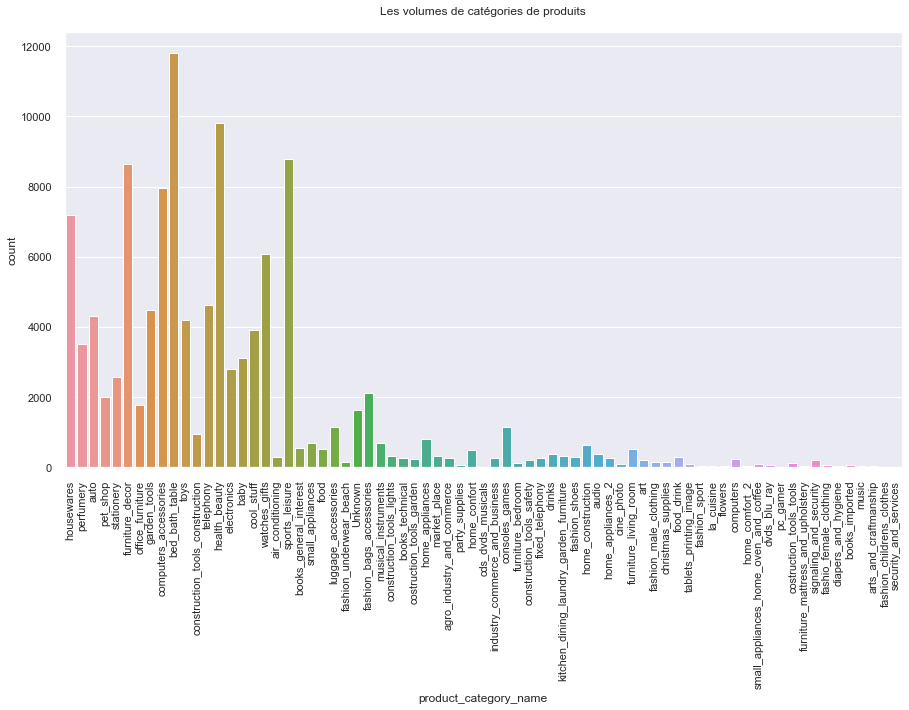

In [206]:
# On regarde les catégories et le nombre de produit
fig = plt.figure(figsize=(15, 8))
sns.countplot(data=df_total, x="product_category_name")
plt.xticks(rotation=90)
plt.title(f"Les volumes de catégories de produits\n")
plt.show()

In [207]:
df_total.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'product_category_name'],
      dtype='object')

In [208]:
len(df_total['product_category_name'].unique())

73

In [209]:
# On decide de renommer des catégories pour en avoir moins
dict_categories = {
#home
'furniture_living_room' : 'home',
'furniture_mattress_and_upholstery' : 'home',
'furniture_bedroom' : 'home',
'furniture_decor' : 'home',
'bed_bath_table' : 'home',
'kitchen_dining_laundry_garden_furniture' : 'home',
'la_cuisine' : 'home',
'home_confort' : 'home',
'home_comfort_2' : 'home',
'christmas_supplies' : 'home',
    
#appliances
'small_appliances' : 'appliances',
'small_appliances_home_oven_and_coffee' : 'appliances',
'home_appliances_2' : 'appliances',
'home_appliances' : 'appliances',
'housewares' : 'appliances',
    
#construction
'construction_tools_construction': 'construction',
'costruction_tools_garden': 'construction',
'costruction_tools_tools': 'construction',
'construction_tools_safety': 'construction',
'construction_tools_lights': 'construction',
'home_construction': 'construction',
'air_conditioning': 'construction',

#office
'office_furniture' : 'office',
'industry_commerce_and_business' : 'office',
'stationery' : 'office',
'agro_industry_and_commerce' : 'office',
'signaling_and_security' : 'office',
'furnitures' : 'office',
'security_and_services' : 'office',
#electronics
'telephony' : 'electronics',
'electronics': 'electronics',
'computers_accessories': 'electronics',
'consoles_games': 'electronics',
'fixed_telephony': 'electronics',
'audio': 'electronics',
'computers': 'electronics',
'tablets_printing_image': 'electronics',
'pc_gamer':'electronics',
#sports_leisure
'sports_leisure' : 'sports_leisure',
'musical_instruments': 'sports_leisure',
'party_supplies': 'sports_leisure',
'luggage_accessories': 'sports_leisure',
#arts
'books' : 'arts',
'books_imported': 'arts',
'books_general_interest': 'arts',
'books_technical': 'arts',
'art': 'arts',
'toys': 'arts',
'cine_photo': 'arts',
'cds_dvds_musicals': 'arts',
'music': 'arts',
'dvds_blu_ray': 'arts',
'arts_and_craftmanship': 'arts',
#fashion
'watches_gifts' : 'fashion',
'fashion_bags_accessories' : 'fashion',
'fashion_underwear_beach' : 'fashion',
'fashion_shoes' : 'fashion', 
'fashion_male_clothing' : 'fashion',
'fashio_female_clothing' : 'fashion',
'fashion_sport' : 'fashion',
'fashion_childrens_clothes' : 'fashion',
#health_beauty
'health_beauty' : 'health_beauty', 
'baby': 'health_beauty',
'diapers_and_hygiene' : 'health_beauty',
'perfumery' : 'health_beauty',
#garden and pets
'flowers' : 'garden_pets',
'pet_shop' : 'garden_pets',
'garden_tools' : 'garden_pets',
#auto
'auto' : 'auto',
#food_drinks
'food_drink' : 'food_drinks',
'food' : 'food_drinks',
'drinks' : 'food_drinks',
#other
'Unknown' : 'other',
'market_place' : 'other', 
'cool_stuff' : 'other'}

#df_total['product_category_name'] = df_total['product_category_name'].map(dict_categories)
df_total['product_category_name'] = df_total['product_category_name'].replace(dict_categories)


In [210]:
df_total['product_category_name'].value_counts()

home              22117
electronics       17470
health_beauty     16476
sports_leisure    10672
appliances         9027
fashion            8833
garden_pets        6520
other              5881
arts               5491
office             5050
auto               4301
construction       2707
food_drinks        1167
Name: product_category_name, dtype: int64

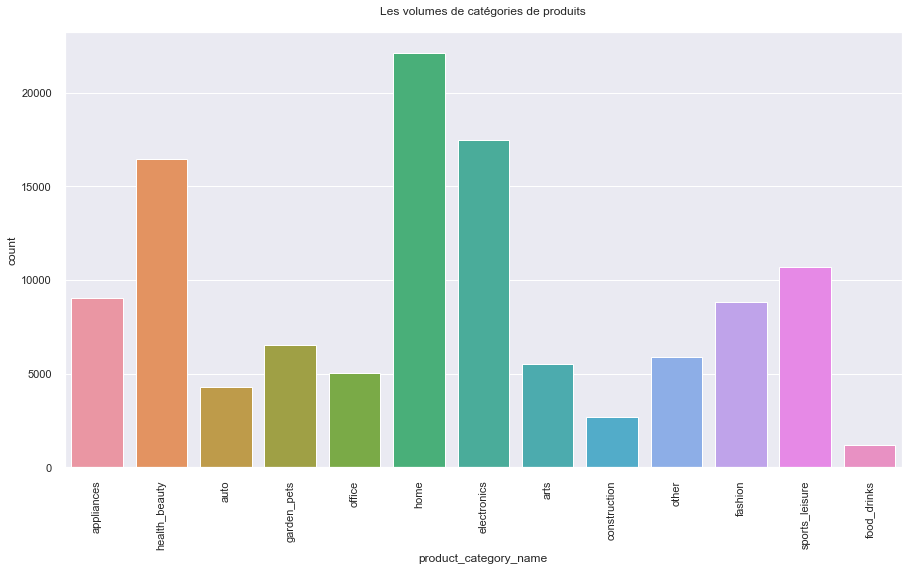

In [211]:
# On regarde les catégories et le nombre de produit
fig = plt.figure(figsize=(15, 8))
sns.countplot(data=df_total, x="product_category_name")
plt.xticks(rotation=90)
plt.title(f"Les volumes de catégories de produits\n")
plt.show()

In [101]:
df_total['product_category_name'].unique()

array(['appliances', 'health_beauty', 'auto', 'garden_pets', 'office',
       'home', 'electronics', 'arts', 'construction', 'other', 'fashion',
       'sports_leisure', 'food_drinks'], dtype=object)

In [102]:
#On regarde les potentielles valeurs manquantes
missingValues(df_total)

,Variable Name,Count,Percentage


In [103]:
df_total.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'product_category_name'],
      dtype='object')

In [104]:
# On supprime les valeurs dont on a pas besoin
df_total.drop(columns = ['freight_value',
                         'customer_state',
                         'customer_city',
                         'customer_zip_code_prefix',
                        ], inplace = True)

In [105]:
# une commande : 10 produits à 109.97 chacun avec une methode paiemnt
# et dont la valeur totale de la commande est 1440.1 payé en 24 fois
df_total[df_total['customer_unique_id'] == '38a4f1deb45ca914dd13c73b41775d71']

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,order_item_id,product_id,price,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name
40884,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,1.0,58efb9b638561ce132216a9a612513e2,109.97,1.0,credit_card,24.0,1440.1,1.0,home
40885,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,4.0,58efb9b638561ce132216a9a612513e2,109.97,1.0,credit_card,24.0,1440.1,1.0,home
40886,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,7.0,58efb9b638561ce132216a9a612513e2,109.97,1.0,credit_card,24.0,1440.1,1.0,home
40887,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,9.0,58efb9b638561ce132216a9a612513e2,109.97,1.0,credit_card,24.0,1440.1,1.0,home
40888,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,10.0,58efb9b638561ce132216a9a612513e2,109.97,1.0,credit_card,24.0,1440.1,1.0,home
56496,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,2.0,872db866d615db59612ac933f43d6b22,109.97,1.0,credit_card,24.0,1440.1,1.0,home
56497,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,3.0,872db866d615db59612ac933f43d6b22,109.97,1.0,credit_card,24.0,1440.1,1.0,home
56498,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,5.0,872db866d615db59612ac933f43d6b22,109.97,1.0,credit_card,24.0,1440.1,1.0,home
56499,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,6.0,872db866d615db59612ac933f43d6b22,109.97,1.0,credit_card,24.0,1440.1,1.0,home
56500,f60ce04ff8060152c83c7c97e246d6a8,78fc46047c4a639e81ff65f0396e02fe,2017-11-28 22:24:18,2017-12-04 22:22:20,38a4f1deb45ca914dd13c73b41775d71,8.0,872db866d615db59612ac933f43d6b22,109.97,1.0,credit_card,24.0,1440.1,1.0,home


In [106]:
# une commande : un produit à 49.99 que le client a payé en 26 fois 
# en montant d'une somme égale à "payment_value"

df_total[df_total['customer_unique_id'] == '569aa12b73b5f7edeaa6f2a01603e381'].sort_values(by='payment_sequential')

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,order_item_id,product_id,price,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name
106657,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,1.0,credit_card,1.0,2.20,5.0,home
106662,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,2.0,voucher,1.0,1.45,5.0,home
106665,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,3.0,voucher,1.0,1.15,5.0,home
106680,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,4.0,voucher,1.0,0.99,5.0,home
106664,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,5.0,voucher,1.0,2.69,5.0,home
106660,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,6.0,voucher,1.0,2.26,5.0,home
106666,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,7.0,voucher,1.0,1.60,5.0,home
106674,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,8.0,voucher,1.0,2.42,5.0,home
106675,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,9.0,voucher,1.0,0.97,5.0,home
106672,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,2017-06-07 12:05:10,2017-06-22 16:04:46,569aa12b73b5f7edeaa6f2a01603e381,1.0,8d37ee446981d3790967d0268d6cfc81,49.99,10.0,voucher,1.0,1.20,5.0,home


In [107]:
# une commande : 21 produit au prix total 31.8 
# le montant total 196 
df_total[df_total['customer_unique_id'] == '4546caea018ad8c692964e3382debd19']

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,order_item_id,product_id,price,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name
113128,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,1.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113129,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,12.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113130,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,13.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113131,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,14.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113132,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,15.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113133,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,16.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113134,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,17.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113135,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,18.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113136,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,19.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty
113137,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017-07-31 18:03:02,4546caea018ad8c692964e3382debd19,20.0,270516a3f41dc035aa87d220228f844c,1.2,1.0,credit_card,2.0,196.11,1.0,health_beauty


#### Export du dataset final pour classification non-supervisée

In [108]:
df_total.shape

(115712, 14)

In [109]:
df_total.to_csv('df_total.csv')